# Probabilistic Models – Spring 2021
## Exercise Session 6
March 3rd 16.15

<span style="color:red">**Carmen Díez**</span>

### Instructions
Make sure the notebook produces correct results when ran sequentially starting from the first cell. You can ensure this by clearing all outputs (`Edit > Clear All Outputs`), running all cells (`Run > Run All Cells`), and finally correcting any errors.

To get points:
1. Submit your answers to the automatically checked Moodle test. 
 - You have 5 tries on the test: the highest obtained score will be taken into account.
 - For numerical questions the tolerance is $1\cdot10^{-4}$.
2. Submit this notebook containing your derivations to Moodle.

## Exercise 1
***

`jkl` is a somewhat standard file format for local scores. The first line in a `jkl`-file states the number of variables/nodes, and the rest of the file is divided into node specific sections. The first line in a section states the variable name and the number of local scores to follow. Each local score is followed by the number of parents for the local score and the parent variables themselves. In the section for variable 0 the line `-193.80 0` thus corresponds to the local score $f(0, \emptyset)$; the line `-193.42 2 1 2` corresponds to the local score $f(0, \{ 1, 2\})$, etc.

Consider the following local scores:

In [2]:
!cat data/1_fix.jkl

4
0 8
-193.80021345773184 0 
-197.16851527924672 1 1
-188.8375185956392 1 2
-189.89041764309678 1 3
-193.4201332025088 2 1 2
-213.92449082704218 2 1 3
-181.94961348240275 2 2 3
-212.20350455559912 3 1 2 3
1 8
-181.3940093476881 0 
-184.76231116920297 1 0
-186.30305389009453 1 2
-161.58080460560382 1 3
-190.88566849696412 2 0 2
-185.6148777895492 2 0 3
-174.47344794910612 2 2 3
-204.7273390223025 3 0 2 3
2 8
-182.99314409357032 0 
-178.0304492314777 1 0
-187.90218863597676 1 1
-151.04672436005933 1 3
-184.15380655923883 2 0 1
-143.1059201993653 2 0 3
-163.93936770356163 2 1 3
-162.21838143211858 3 0 1 3
3 8
-169.22877645649714 0 
-165.31898064186208 1 0
-149.41557171441286 1 1
-137.28235672298615 1 2
-166.17154726220832 2 0 1
-130.3944516097497 2 0 2
-125.45275078199774 2 1 2
-144.23612213508807 3 0 1 2


Use dynamic programming to find (one of) the highest scoring DAG(s) (i.e. maximizing the marginal likelihood or the global BDeu score).

Report the obtained score for the DAG.

### Solution
Highest scoring DAG with dynamic programming: having an specific causal order calculat the DAG that maximizes the score. We know the potential parents and we take the option with those parents (or less) that maximizes the score.

In [202]:
import pandas as pd 
import numpy as np
from itertools import permutations
import graphviz

In [77]:
def append_to_df(node, local_score, parents):
    return df.append({'node': node, 'local_score': local_score, 'parents': parents}, ignore_index=True)

In [195]:
def best_network(causal_order):
    best_graph = pd.DataFrame()
    causal_order_str = [str(n) for n in causal_order]
    
    for i in range(n_nodes):
        df_node = df[df['node'] == causal_order_str[i]]
        potential_parents = causal_order_str[:i]
        
        n_local = len(df_node.index)
        
        valid = [True]*n_local
        for j in range(n_local):
            ps = df_node['parents'].iloc[j]
            for k in range(len(ps)):
                if ps[k] not in potential_parents:
                    valid[j] = False
                    break

        df_valid = df_node[valid]
        
        valid_max = df_valid['local_score'].max()
        row_max = df_valid[df_valid['local_score'] == valid_max]
        best_graph = best_graph.append(row_max, ignore_index=True)
    return best_graph

In [204]:
#reading the file
cols = ['node', 'local_score', 'parents']
df = pd.DataFrame(columns = cols)

f = open('data/1_fix.jkl')
n_nodes = int(f.readline())
for _ in range(n_nodes):
    node_and_n_local = f.readline().split()
    node = node_and_n_local[0]
    n_local = int(node_and_n_local[1])
    for _ in range(n_local):
        local = f.readline().split()
        local_score = float(local[0])
        n_parents = int(local[1])
        if n_parents==0:
            parents = ''
        else:
            parents = []
            for i in range(n_parents):
                parents += [local[2+i]]
            parents = "".join(parents)
        
        df = append_to_df(node, local_score, parents)

In [206]:
#all possible causal orders
perms = permutations([0,1,2,3])
orders = list(perms)

#best network for each possible causal order
best_networks = []
for causal_order in orders:
    best_networks.append(best_network(causal_order))

#scores for each network
scores = [df['local_score'].sum() for df in best_networks]

# find id of maximum
id_max = np.argmax(scores)

print('Maximum Score: ', scores[id_max] )
best_networks[id_max]

Maximum Score:  -663.805918904563


,node,local_score,parents
0,0,-193.800213,
1,2,-178.030449,0
2,3,-130.394452,02
3,1,-161.580805,3


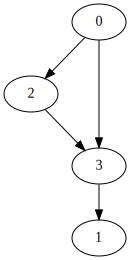

In [203]:
g = graphviz.Digraph(engine='dot', graph_attr={'rankdir':'TB', 'size':'20', 'nodesep':'1'})

g.node("0")
g.node("1")
g.node("2")
g.node("3")

g.edge("0","2")
g.edge("0","3")
g.edge("2","3")
g.edge("3","1")

g

## Exercise 2
***

Given the local scores above, find an optimal tree structure using the Chow-Liu algorithm.

Report the obtained score for the DAG.

### Solution
Chow-liu algorithm: 
1. Initialize a complete undirected weighted graph G on N with edge weights $w_{ij}=f(i,j)-f(i,\emptyset)=f(j,i)-f(j,\emptyset)$.
2. Find a maximum (weight) spanning tree G' of G (using Kruskal algorith, for example).
3. Choose an arbitrary node as a root and orient all edges in G' away from it.

In [274]:
def f(node, parents):
    if type(parents) == list:
        parents = ''.join([str(n) for n in parents])
    if type(node) != str:
        node = str(node)
    return df[(df['node']==node) & (df['parents']==parents)]['local_score'].item()

In [277]:
weights = dict()
for i in range(n_nodes):
    weights[i] = dict()
    for j in range(n_nodes):
        if i!=j and i<j:
            weights[i][j] = f(i, [j]) - f(i, [])
            print(i, '-', j, ':', weights[i][j])

0 - 1 : -3.3683018215148763
0 - 2 : 4.962694862092633
0 - 3 : 3.9097958146350607
1 - 2 : -4.909044542406434
1 - 3 : 19.81320474208428
2 - 3 : 31.946419733510993


We perform Kruskal with weights obtained. We choose the edges with the highest scores without getting cycles:

1. **2 - 3:** 31.946419733510993
2. **1 - 3:** 19.81320474208428
3. **0 - 2:** 4.962694862092633

We have connected all nodes. We choose, for example, 0 as root and we get the following tree: **0 -> 2 -> 3 -> 1**. Then, we calculate the tree's score.

In [278]:
score = f(0,'') + f(2,'0') + f(3,'2') + f(1, '3')
print('Score:', score)

Score: -670.6938240177994


## Exercise 3
***

For the local scores above, run basic greedy hill climbing starting from the empty network until the score cannot be improved by a local operation. Do not perform any zero gain operations and make sure not to form cyclic networks.

Report the obtained score for the DAG.

### Solution
Greedy Hill climbing algorithm:

Start with no edges and then perform operations that makes the score better:

* Add an edge.
* Delete an edge.
* Reverse an edge.

At each search step, we find the best neighbor and move to it.

In [279]:
# 3.0

score0 = f(0,'') + f(1,'') + f(2,'') + f(3,'')
print('Intial Score (with no edges): ', score_0)

#The first 3 steps are the same as in the Chow liu algorithm.
# edge 2->3, gain weights[2][3]
gain1 = weights[2][3] #f(3, '2') - f(3, '')
score1 = score0 + gain1
print('2->3 gain: ', gain1)

# edge 3->1, gain weights[1][3]
gain2 = f(1,'3')-f(1,'')
bdeu_2 = bdeu_1 + gain2
print('add 3->1 gain: ', gain2)

print('Step 3 -----------------------------------------')
# Step 3
gain3 = f(2,'0')-f(2,'')
bdeu_3 = bdeu_2 + gain3
print('add 0->2 gain: ', gain3)


print('Step 4 -----------------------------------------')
# Step 4
# Reversals
# rev 2->3
gain_rev23 = f(0,'') + f(2, '03') + f(3, '') + f(1, '3') - bdeu_3
print('rev 2->3 gain: ', gain_rev23)
#rev 1->3
gain_rev31 = f(0,'') + f(2, '0') + f(3, '12') + f(1, '') - bdeu_3
print('rev 3->1 gain: ', gain_rev31)

# Adding new edges (no cycles)
gain_add03 = f(0,'') + f(2, '0') + f(3, '02') + f(1, '3') - bdeu_3
print('add 0->3 gain: ', gain_add03)
gain_add01 = f(0,'') + f(2, '0') + f(3, '2') + f(1, '03') - bdeu_3
print('add 0->1 gain: ', gain_add01)
gain_add21 = f(0,'') + f(2, '0') + f(3, '2') + f(1, '23') - bdeu_3
print('add 2->1 gain: ', gain_add21)

bdeu_4 = bdeu_3 + gain_add03


print('Step 5 -----------------------------------------')
# Step 5
# rev 3->1
gain_rev23 = f(0,'') + f(2, '0') + f(3, '012') + f(1, '') - bdeu_4
print('rev 3->1 gain: ', gain_rev23)
# rev 0->2
gain_rev02 = f(0,'2') +f(2, '') + f(3, '02') + f(1, '3') - bdeu_4
print('rev 0->2 gain: ', gain_rev02)
# rev 2->3
gain_rev23 = f(0,'') + f(2, '0') + f(3, '0') + f(1, '3') - bdeu_4
print('rev 2->3 gain: ', gain_rev23)
# add 0->1
gain_add01 = f(0,'') + f(2, '0') + f(3, '02') + f(1, '03') - bdeu_4
print('add 0->2 gain: ', gain_add01)
# del 3->1
gain_del01 = f(0,'') + f(2, '0') + f(3, '02') + f(1, '') - bdeu_4
print('del 0->1 gain: ', gain_del01)
# del 0->2
gain_del02 = f(0,'') + f(2, '0') + f(3, '02') + f(1, '3') - bdeu_4
print('del 0->2 gain: ', gain_del02)
# del 2->3
gain_del23 = f(0,'') + f(2, '0') + f(3, '0') + f(1, '3') - bdeu_4
print('del 2->3 gain: ', gain_del23)

print('No more iterations ----------------------------')
print('Bdeu score: ', bdeu_4)

Intial Bdeu Score (no edges):  -727.4161433554874
Step 1 -----------------------------------------
add 2->3 gain:  31.946419733510993
Step 2 -----------------------------------------
add 3->1 gain:  19.81320474208428
Step 3 -----------------------------------------
add 0->2 gain:  4.962694862092633
Step 4 -----------------------------------------
rev 2->3 gain:  2.978109298601339
rev 3->1 gain:  -7.983598801095923
add 0->3 gain:  6.887905113236457
add 0->1 gain:  -24.034073183945452
add 2->1 gain:  -12.892643343502414
Step 5 -----------------------------------------
rev 3->1 gain:  -33.65487526742277
rev 0->2 gain:  0.0
rev 2->3 gain:  -34.924529032112446
add 0->2 gain:  -24.034073183945452
del 0->1 gain:  -19.81320474208428
del 0->2 gain:  0.0
del 2->3 gain:  -34.924529032112446
No more iterations ----------------------------
Bdeu score:  -663.805918904563


## Exercise 4
***

When finding a highest scoring DAG over a set of local scores, one can reduce the size of the problem by pruning (i.e., omitting) any local scores $f(X_i, Q)$ for which there is another local score $f(X_i, P)$ such that  $f(X_i, P) > f(X_i, Q)$ and $P \subset Q$.  Prove that this is correct, i.e. show that $X_i$ does not have parent set $Q$ in a highest scoring DAG if there is another parent set $P$ such that $f(X_i, P) > f(X_i, Q)$ and $P \subset Q$.

In [ ]:
# Provide your answer in cells here

## Exercise 5
***

Causal effects $P(Y|do(X=x))$ denote probability distributions over Y that result when $X$ is forced to some value $x$ (instead of observing that value). For (causal) Bayesian networks, causal effects can be calculated by taking the BN factorization and deleting the CPD factors for the intervened nodes (this is equivalent to deleting edges in the graph because if a variable is forced to a value it is no longer influenced by its parents), and then summing out variables $V\setminus \{X,Y\}$. Show  that equalities  $P(E|do(C=T))=P(E|C=T)$, $P(A|do(B=F))=P(A)$, $P(E|do(A=T))=P(E|A=T)$ apply in the following network.

![](6.5.svg)

In [5]:
!for v in {A..E}; do echo "CPT for node "$v; cat "data/cpt"$v".tsv"; echo ""; done

CPT for node A
True	False
0.6	0.4

CPT for node B
A	True	False
1	0.2	0.8
0	0.25	0.75

CPT for node C
A	True	False
1	0.8	0.2
0	0.1	0.9

CPT for node D
B	C	True	False
1	1	0.95	0.05
1	0	0.9	0.1
0	1	0.8	0.2
0	0	0	1

CPT for node E
C	True	False
1	0.7	0.3
0	0	1



In [ ]:
# Provide your answer in cells here

## Exercise 6
***

Using the above network and explanation, calculate the causal effect $P(D|do(B=T))$. Show that it does not equal to $P(D)$ or $P(D|B=T)$.

Report:
- $P(D=T|do(B=T))$.
- $P(D=T)$.
- $P(D=T|B=T)$.

In [6]:
# Provide your answer in cells here